<a href="https://colab.research.google.com/github/NinaAbeyratne/MU-Practice/blob/main/MU_Centralized_Systems_Trial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning / CF-k (Simple Forget via Retraining on Remaining Data)

Remove a target sample/class → re-train (fine-tune) on the rest → reset last layers to “forget” the representation of the removed data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [4]:
# --- Dataset ---
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


### Explore the dataset

In [5]:
# Class names
classes = trainset.classes
print("Classes:", classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
# Dataset size
print("Total training samples:", len(trainset))

Total training samples: 50000


In [7]:
# Count samples per class
from collections import Counter
labels = [label for _, label in trainset]
class_counts = Counter(labels)
for i, count in class_counts.items():
    print(f"{classes[i]:>10}: {count}")

      frog: 5000
     truck: 5000
      deer: 5000
automobile: 5000
      bird: 5000
     horse: 5000
      ship: 5000
       cat: 5000
       dog: 5000
  airplane: 5000


In [10]:
# Visualize a few random samples
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # img = img / 2 + 0.5  # normalize if needed
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

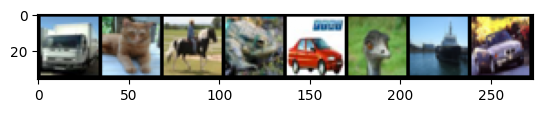

truck cat   horse frog  automobile bird  ship  automobile


In [12]:
# Get a batch of images
dataiter = iter(torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True))
images, labels = next(dataiter)

# Show images and labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

Unlearning Request

In [13]:
forget_class = 3  # e.g., forget 'cat' class
retain_indices = [i for i, (_, label) in enumerate(trainset) if label != forget_class]
retain_subset = torch.utils.data.Subset(trainset, retain_indices)
trainloader = torch.utils.data.DataLoader(retain_subset, batch_size=64, shuffle=True)

In [14]:
# --- Model ---
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


In [15]:
# --- Fine-tune to forget ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(3):  # small fine-tune
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
print("✅ Finished fine-tuning (forgetting 'cat')")

✅ Finished fine-tuning (forgetting 'cat')


Testing

In [16]:
# --- Test if the model "forgot" the target class ---

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [17]:
# Reload CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                       transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = testset.classes
forget_class = 3  # 'cat'

In [18]:
model.eval()
correct, total = 0, 0
forget_correct, forget_total = 0, 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Overall accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Accuracy specifically on forgotten class
        forget_mask = labels == forget_class
        forget_total += forget_mask.sum().item()
        forget_correct += (predicted[forget_mask] == labels[forget_mask]).sum().item()

In [19]:
overall_acc = 100 * correct / total
forget_acc = 100 * forget_correct / forget_total if forget_total > 0 else 0

In [20]:
print(f"🔹 Overall Test Accuracy: {overall_acc:.2f}%")
print(f"🔹 Accuracy on forgotten class ({classes[forget_class]}): {forget_acc:.2f}%")

🔹 Overall Test Accuracy: 74.91%
🔹 Accuracy on forgotten class (cat): 0.00%


In [21]:
if forget_acc < 20:
    print("✅ The model seems to have forgotten the target class effectively.")
else:
    print("⚠️ The model still remembers much about the target class.")

✅ The model seems to have forgotten the target class effectively.
